# week 04
# posterior predictive checking

This week we will focus on posterior predictive checking. We start out reviewing our Bayesian Inference Engine, then we work through posterior predictive checking with an example of farmers in Iowa.



## load libraries

In [3]:
# for reading json files
import json

# numerical libraries
import numpy as np
import scipy as sp
import pystan

# pandas!
import pandas as pd

# plotting libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
%pylab inline

# pretty graphs
sns.set(style="whitegrid")

Populating the interactive namespace from numpy and matplotlib


/Users/daneel/miniconda3/envs/stan_dev/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Bayesian Inference Engine
You can answer almost any question using the Bayesian inference engine that we outline below. While this is a general way of conducting research, it is specifically Bayesian when it comes to taking a theory to the data.

If you follow these steps, you will produce a set of empirically tested insights from a transparent and repeatable model that you and others can build upon. Furthermore, these steps minimize the chance that your model produces a result for the wrong reason or fails to capture key features in your data. 

Talking to colleagues and seeking out diverse perspectives is central to your Bayesian inference efforts, and each step below presents an opportunity to consult with others. We set off coding best practices with _italics_.

## Develop the question
Questions from the world do not arise in a form that is easily answered by a statistical model. Often the necessary data does not exist. Either the action of interest is indirectly observed or data exists in an aggregated form. So there is some amount of work at the beginning in developing the right question to pose to a statistical model. Ponder and scrutinize various forms of the question and iterate until you arrive at one that achieves the right balance of feasibility and usefulness.

## Research methods and subject
Search far and wide for methodological and topical research related to your question. This is a great opportunity to consult people outside of your discpline. Interview subject matter experts. Read some history. Immerse yourself in the topic. What's been done before? 

## Develop Theory
Develop a theory to inform your data choices and to ensure that you're building a model to the questions you have vice the data you have on hand.

## Gather data
Gather as much data as you can and store it in a machine readable format that includes all of the information about what the data is, where you got it, and what each column means. Store raw data, scripts to transform it, and transformed/clean data. _You should have one repeatable script that takes your raw data files as inputs and outputs cleaned data suitable for modeling. Assign unique identifiers to your raw data, transform scripts, and cleaned data._

## Build a model
For a Bayesian, a model is a prior distribution and likelihood. Choosing both necessarily involves a compromise among "scientific knowledge, mathematical convenience, and computational tractability". You should have some ideas for where to start from your research, but you will almost always find yourself in new territory. Take an interative approach. Start small, find the error modes of each model, and use those deficiencies to guide your next step. _Document each model file and treat it as software. Check it into a code repository, assign a unique identifier to each model version, and label all results generated by a model with that identifier._ 

## Perform prior predictive checks
Prior predictive checking serves two purposes: ensuring your priors rule out outrageous values yet maintain the ability to generate many possibilities, and to surface coding errors. This stage involves the Bayesian two-step of generating values from the prior then simulating datasets from the model. Once you have these data samples you can check your code by conducting inference and determining how good the model fits the data, and you can construct a flip-book of prior-generated datasets to assess whether your priors are informed but flexible enough. Is the model capable of generating data resembling your observed data? Are your priors unduly constraining your model, ie is it capable of detecting potentially competing possibilities? _For each model identifier, store a script that recreates the series of prior predictive checks that informed your decisions about the prior and likelihood._

## Recover the posterior
Carry out Bayesian inference by updating your prior knowledge with observed data. Perform a battery of checks on your estimation technique to ensure that you, in fact, are able to generate samples from a posterior. Experience gained during prior predictive checking will inform how your estimation technique might fail with real data. _Store posterior draws in a machine readable format that includes the model and data identifiers as well as the commands you used to estimate the model. Assign a unique identifier to the posterior data object. If your results got lost, could you tell a computer to recreate them?_ 

## Conduct posterior predictive checks
Posterior predictive checks uncover how your model fails to match important features of your data. You have to decide what features of the data are important to design good posterior checks, and this will always depend on the question you are attempting to answer. Once you decide what is most important to check, you next choose whether to assess failures with a graphic, predictive performance diagnostic, test statistic, or all three. Failures provide a path for model expansion or revision. _Create a script that takes a posterior object and implements all of your posterior checks._

## Document results, clean code, clear out trial results
After you complete modeling but before you write up your results, pause to ensure all your model and estimation code is well-documented and to clear trial results or data from storage. Create a pipeline script that includes the data-cleaning, estimation, and posterior checking scripts into one process that reproduces all of your results. Can you explain the process to someone else? If possible, ask someone to run the script and reproduce all ouputs. Finally, delete any trial results or data from storage to reduce costs and increase the ease with which you and others can access your findings.


## Write up your results
Translating posterior quantities into something that answers the original question in a way that is useful to people who are not Bayesian statisticians is a crucial step. Failure to convey appropriate nuance and uncertainty in your conclusions can lead to the misinterpretation or exaggeration of your findings. Wherever possible provide the context of credible intervals with point estimates. Be forthcoming about what the model fails to capture, why, and how you could address this failure with additional data or model development. Provide intuitive, non-technical explanations of how your model works and the assumptions it makes. Spend a lot of time trying various ways to depict your results in a visually pleasing way. Often a story can be told much more efficiently through a series of graphics and brief textual explanations. _Write a script that generates all of the graphics, tables, and statistics used in your write up. Consider assigning a unique identifier to each to facilitate transparency and reproducibility. Add this script to the pipeline script created in the previous step to produce a memory tape of your modeling process for future inspection by you and others._

## Example: farming in Dubuque, IA

<img src="iowa_corn.jpg" style="height:250px">

Dubuque, Iowa produces over 200 bushels of corn per acre, one of the higher rates of corn production across the state. The optimal planting time for corn in this county begins on April 10 and ends April 30. However, weather plays a big role in how the seed fares. If it is warm and wet during this period, production will be negatively affected.

We look at data from 2000 through 2018 from NOAA (daily average temperature and daily precipitation) and the USDA (annual corn production in Dubuque).


#### Notation
* _HWPD = hot wet planting day_


* An HWPD is a day between 10 and 30 April when the daily temperature averaged greater than 55 degrees Fahrenheit and the daily average rainfall was greater than 0.5 inches.

In [4]:
# load and display data
dubuque_corn_prod = pd.read_csv('../data/iowa_corn_data.csv')
dubuque_corn_prod.head()

,year,state,county,crop,acres_planted,acres_harvested,bushels_produced,bushel_per_acre,hot_wet_planting
0,2000,Iowa,Dubuque,corn,124000,117900,17838000,151.3,4
1,2001,Iowa,Dubuque,corn,115000,108500,17133000,157.9,4
2,2002,Iowa,Dubuque,corn,115800,106500,18500000,173.7,6
3,2003,Iowa,Dubuque,corn,124000,112000,17600000,157.1,5
4,2004,Iowa,Dubuque,corn,127000,118000,21590000,183.0,3


In [5]:
# summarize the columns
dubuque_corn_prod.describe()

,year,acres_planted,acres_harvested,bushels_produced,bushel_per_acre,hot_wet_planting
count,19.000000,19.000000,19.000000,1.900000e+01,19.000000,19.000000
mean,2009.000000,137647.368421,127163.157895,2.311432e+07,180.721053,2.000000
std,5.627314,12524.924858,11886.089467,4.224034e+06,20.081683,1.855921
min,2000.000000,115000.000000,106500.000000,1.713300e+07,149.400000,0.000000
25%,2004.500000,127500.000000,118100.000000,1.999050e+07,164.200000,0.000000
50%,2009.000000,138500.000000,127000.000000,2.232600e+07,183.000000,2.000000
75%,2013.500000,149500.000000,137250.000000,2.647400e+07,190.550000,3.000000
max,2018.000000,151500.000000,144600.000000,3.057900e+07,215.100000,6.000000


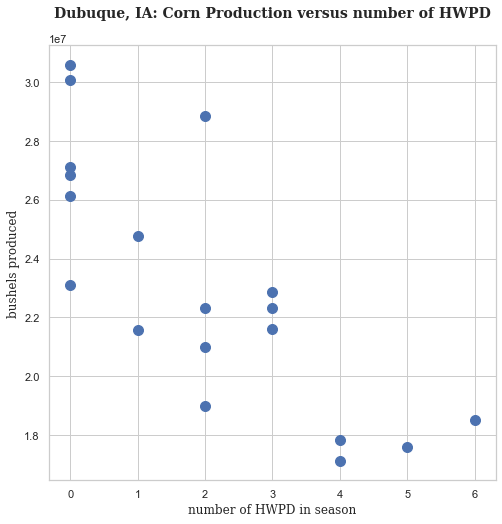

In [6]:
# plot relationship between hot wet planting days (HWPD) and corn production in Dubuque, Iowa
plt.figure(figsize=(8,8))
plt.scatter(dubuque_corn_prod.hot_wet_planting,dubuque_corn_prod.bushels_produced,s=100)
plt.title('Dubuque, IA: Corn Production versus number of HWPD',y=1.05,
          fontsize=14,fontfamily='serif',fontweight='bold')
plt.ylabel('bushels produced',fontfamily='serif')
plt.xlabel('number of HWPD in season',fontfamily='serif');

There is a very strong relationship between the number of HWPDs and annual corn production. 

#### What percent of years had 4 or more HWPDs?

In [7]:
# create indicator for days >= 4
dubuque_corn_prod['hwpd_gt_3'] = [1 if x > 3 else 0 for x in dubuque_corn_prod.hot_wet_planting]

In [8]:
# how many hot-wet days in data?
sum(dubuque_corn_prod.hwpd_gt_3)

4

In [9]:
# converting to a percent
sum(dubuque_corn_prod.hwpd_gt_3) / len(dubuque_corn_prod)

0.21052631578947367

#### How much does this affect corn production in Dubuque?

In [10]:
dubuque_corn_prod.groupby(['hwpd_gt_3']).mean()[['bushels_produced']]

,bushels_produced
hwpd_gt_3,
0,2.454007e+07
1,1.776775e+07


In [11]:
# this is an almost 30 percent decrease in production
(1.776 - 2.454) / 2.454

-0.27628361858190714

### How can we model the number of HWPDs?

* Discrete and positive random variable.
* A count

A Poisson distribution!

We dust off Stan and fit a poisson distribution to the number of HWPDs in a season.

In [12]:
# a stan model to fit a poisson distribution
f = open('../stan/iowa_hwpd_poisson.stan', 'r')
file_contents = f.read()
print (file_contents)
f.close()

// fit a poisson model to the number of HWPDs in Dubuqe
data {
  int<lower=1> N; // number of datapoints
  int hwpd[N];    // random variable
}
parameters {
  real<lower=0> lambda;  // rate of events
}
model {
  // priors
  lambda ~ normal(0,5);
  
  // likelihood
  hwpd ~ poisson(lambda);
}
generated quantities {
  real hwpd_sim;    // simulated values from the posterior
  hwpd_sim = poisson_rng(lambda); // sample from poisson distribution
}



In [19]:
pm = pystan.StanModel(file='../stan/iowa_hwpd_poisson.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e2a6e93e66411ee99bb8b3d96f34cdef NOW.


In [14]:
# feed stan some data
hwpd_dict = {'N':len(dubuque_corn_prod.hot_wet_planting),'hwpd':dubuque_corn_prod.hot_wet_planting}

In [20]:
# conduct MCMC using Stan
hwpd_draws = pm.sampling(data=hwpd_dict, iter=1000, chains=4)

In [21]:
# give us a dictionary containing posterior draws for each parameter in the model
hwpd_pstr = hwpd_draws.extract(permuted=True)

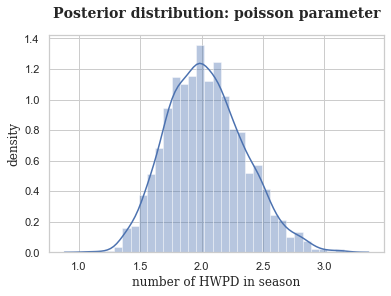

In [43]:
sns.distplot(hwpd_pstr['lambda'])
plt.title('Posterior distribution: poisson parameter',y=1.05,
          fontsize=14,fontfamily='serif',fontweight='bold')
plt.ylabel('density',fontfamily='serif')
plt.xlabel('number of HWPD in season',fontfamily='serif');

In [44]:
# mean number of HWPDs from 2000 to 2018
np.mean(hwpd_pstr['lambda'])

2.0352700322724075

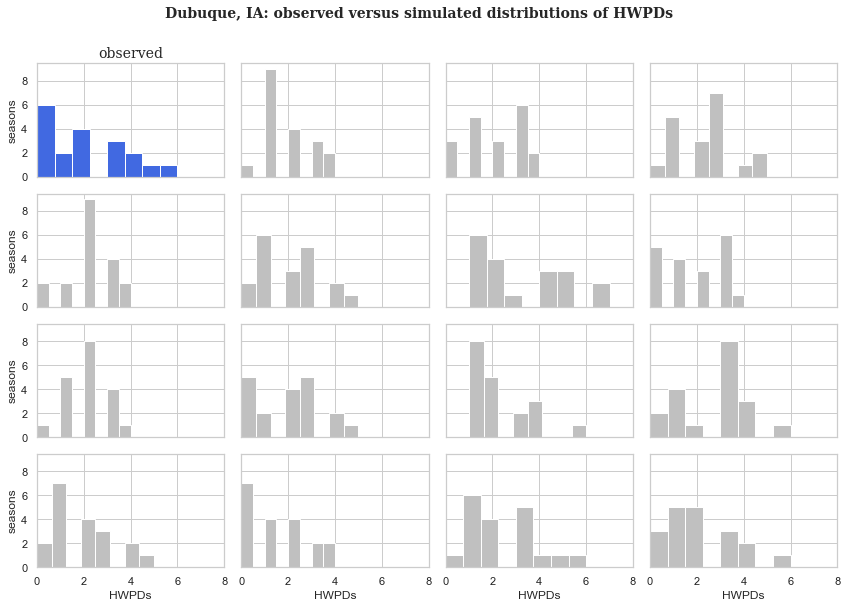

In [118]:
# Initialise the figure and a subplot axes.
num_rows = 4
num_cols = 4
fig, ax = plt.subplots(num_rows, num_cols, figsize=(12, 8),sharex=True,sharey=True)

# let's pick 8 random posterior samples
idx = np.random.choice(np.arange(hwpd_pstr['hwpd_sim'].shape[0]),size=16,replace=False)

# overall title
fig.suptitle('Dubuque, IA: observed versus simulated distributions of HWPDs',
             y=1.05,fontsize=14,fontfamily='serif',fontweight='bold')

# plots of poissons
c = 0
for i in range(num_rows):
    for j in range(num_cols):
        if i == 0 and j == 0:
            # observed data
            ax[0,0].hist(dubuque_corn_prod.hot_wet_planting,bins=8,density=False,color='royalblue')
            ax[0,0].set_xlim(0,8)
            ax[0,0].set_title('observed',fontsize=14,fontfamily='serif')
        else:
            # simulated data plots
            ax[i,j].hist(hwpd_pstr['hwpd_sim'][idx[c],:],bins=8,density=False,color='silver')
            c += 1
            
        # label
        if j == 0:
            ax[i,j].set_ylabel('seasons')
        if i == num_rows - 1:
            ax[i,j].set_xlabel('HWPDs')

# make the plot prettier
plt.tight_layout()
plt.show();

#### What are the major differences between the observed and simulated distributions?

1. Observed has many more zeros than the simulated data
2. Observed has a higher percentage of seasons with more than 3 HWPDs.

To see this more clearly, here is a distribution plot with 200 simulations from out fitted distribution against the observed distribution.

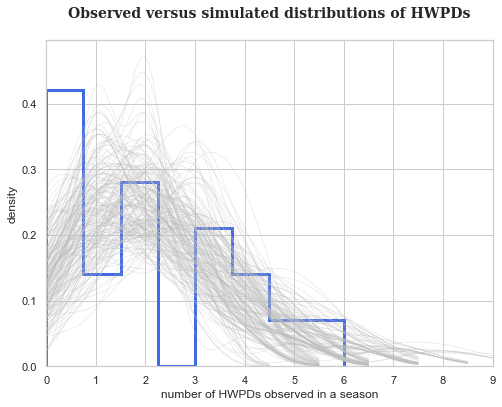

In [119]:
# let's pick 8 random posterior samples
num_samp = 200
idx = np.random.choice(np.arange(hwpd_pstr['hwpd_sim'].shape[0]),size=num_samp,replace=False)

plt.figure(figsize=(8,6))

# plot samples from posterior
for i in range(num_samp):
    sns.kdeplot(hwpd_pstr['hwpd_sim'][idx[i],:],bw=0.5,lw=0.5,alpha=0.5,color='silver')

# plot data
plt.hist(dubuque_corn_prod.hot_wet_planting,histtype='step',bins=8,density=True,lw=3,color='royalblue',label='observed')

# label
plt.title('Observed versus simulated distributions of HWPDs',
             y=1.05,fontsize=14,fontfamily='serif',fontweight='bold')
plt.xlabel('number of HWPDs observed in a season')
plt.ylabel('density')
plt.xlim(0,9);

#### How important are these deviations between the observed versus simulated number of HWPDs?

Without knowing what kind of question we're trying to answer, it is not clear which deviations are most problematic. Suppose we are the sole corn processor in Dubuque, and it is costly for us to run our processing facility when the total annual production is less than 20 million bushels. Since this event is much more likely to occur when the number of HWPDs is greater than three, we will focus our evalution on this statistic.

We will use samples from our model that we generated earlier to compute the number of seasons over a 19 year period that have more than 3 HWPDs, then compare the percent of histories above and below the observed number.

In [52]:
# get number of experiments from previously estimated Stan model
num_expr = hwpd_pstr['hwpd_sim'].shape[0]

# sample from a poisson distribution with mean 2
poisson_expr = np.array(hwpd_pstr['hwpd_sim'].reshape(num_expr*len(dubuque_corn_prod)),dtype=int)
expr_idx = np.mod(np.arange(num_expr*len(dubuque_corn_prod)),num_expr)+1

# put it in a dataframe
expr_df = pd.DataFrame(np.vstack([expr_idx,poisson_expr]).T,columns=['experiment','num_hwpd'])

# create an indicator variable to count number of HWPD
expr_df['gt_three'] = [1 if x > 3 else 0 for x in expr_df.num_hwpd]
expr_df.head(10)

,experiment,num_hwpd,gt_three
0,1,1,0
1,2,0,0
2,3,2,0
3,4,6,1
4,5,4,1
5,6,1,0
6,7,2,0
7,8,4,1
8,9,0,0
9,10,1,0


In [53]:
# we use pandas groupby to compute the percent of HWPD > 3 for each experiment
sim_gt_three = expr_df.groupby(['experiment']).sum()['gt_three'] / len(dubuque_corn_prod)

In [54]:
# how many years with HWPD > 3 in each experiment?
expr_df.groupby(['experiment']).sum()[['gt_three']].head()

,gt_three
experiment,
1,2
2,1
3,2
4,4
5,1


#### What do some of these experiments looks like?

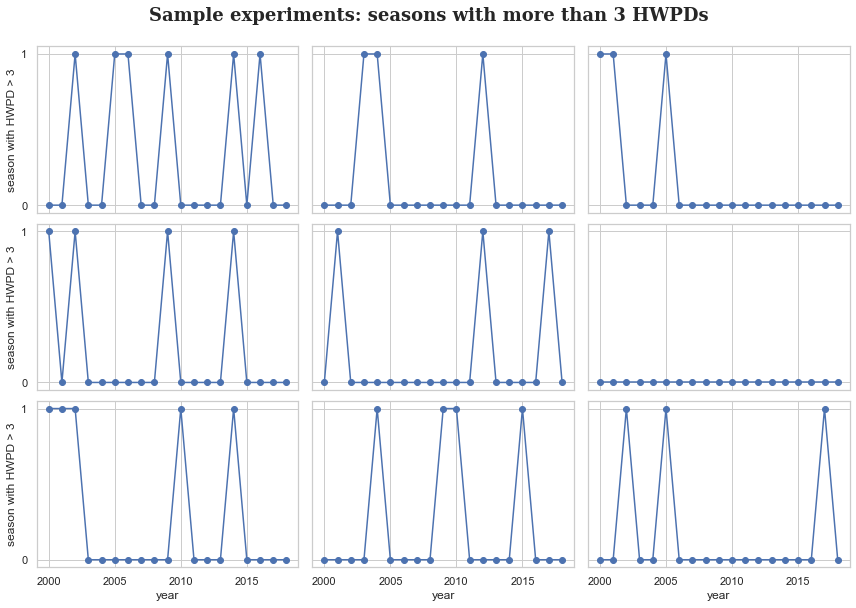

In [55]:
# Initialise the figure and a subplot axes.
num_rows = 3
num_cols = 3
fig, ax = plt.subplots(num_rows, num_cols, figsize=(12, 8),sharex=True,sharey=True)

# pick num_rows * num_cols
idx = np.random.choice(np.arange(num_expr),num_rows*num_cols,replace=False)

# x labels
xlabels = 2000 + np.arange(len(dubuque_corn_prod))

# overall title
fig.suptitle('Sample experiments: seasons with more than 3 HWPDs',
             y=1.05,fontsize=18,fontfamily='serif',fontweight='bold')

c = 0

for i in range(num_rows):
    for j in range(num_cols):
        ax[i,j].plot(xlabels,expr_df[expr_df.experiment == idx[c]].gt_three,'o-')
        ax[i,j].set_yticks([0,1])
        if i == (num_rows - 1):
            ax[i,j].set_xlabel('year')
            
        if j == 0:
            ax[i,j].set_ylabel('season with HWPD > 3')
        c += 1
                             
# make the plot prettier
plt.tight_layout()
plt.show();

#### What does the distribution of the number of seasons with HWPD > 3 look like?

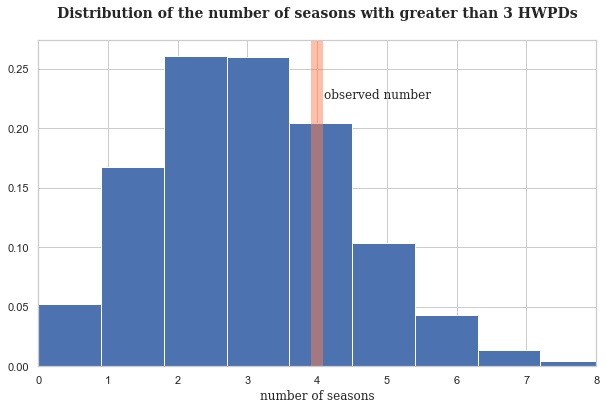

In [56]:
plt.figure(figsize=(10,6))
plt.hist(expr_df.groupby(['experiment']).sum()['gt_three'],density=True,bins=10,label='')
plt.axvline(sum(dubuque_corn_prod.hwpd_gt_3),lw=12,alpha=0.5,color='coral')
plt.text(4.1,0.225,'observed number',fontfamily='serif',fontsize=12)
plt.title('Distribution of the number of seasons with greater than 3 HWPDs',y=1.05,
          fontsize=14,fontfamily='serif',fontweight='bold')
plt.xlabel('number of seasons',fontfamily='serif')
plt.xlim(0,8);

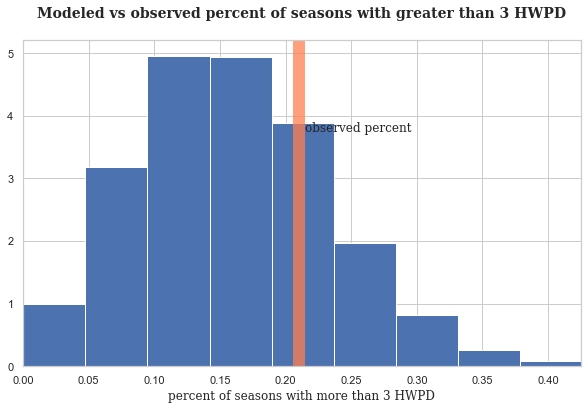

In [57]:
plt.figure(figsize=(10,6))
plt.hist(sim_gt_three,density=True,bins=10,label='')
plt.axvline(sum(dubuque_corn_prod.hwpd_gt_3) / len(dubuque_corn_prod),lw=12,alpha=0.75,color='coral')
plt.text(0.215,3.75,'observed percent',fontfamily='serif',fontsize=12)
plt.title('Modeled vs observed percent of seasons with greater than 3 HWPD',y=1.05,
          fontsize=14,fontfamily='serif',fontweight='bold')
plt.xlabel('percent of seasons with more than 3 HWPD',fontfamily='serif')
plt.xlim(0,0.425);

### Do we have a good model?

If our model is correct, we would expect to observe an average of 4 growing seasons with more than 3 HWPDs in a 19 year period. Instead we expect 2.76 seasons with more than 3 HWPDs:

In [58]:
np.mean(expr_df.groupby(['experiment']).sum()['gt_three'])

2.884

How often does our model produce 4 or more years that meet our criterion?

In [61]:
# observed percentage of years in a 19 year period with more than 3 HWPD
obs_prcnt = sum(dubuque_corn_prod.hwpd_gt_3) / len(dubuque_corn_prod)

# how many times do we observe that or more in the model?
modeled_prcnt = len(sim_gt_three[sim_gt_three >= obs_prcnt]) / len(sim_gt_three)
print(modeled_prcnt)

0.333


This means that we observe less than 4 about 75 percent of the time and more than or equal to 4 about 25 percent of the time. So our model does a decent job of predicting our statistic of interest.

* What would we say if our model produced 4 or more seasons with more than 3 HWPD 99 percent of the time?

* What would we say if our model produced less than 4 seasons with more than 3 HWPD 99 percent of the time?

* Would our assessment change?

Another way to see this is to plot the empirical CDF of the percent of seasons meeting our criterion over all experiments.

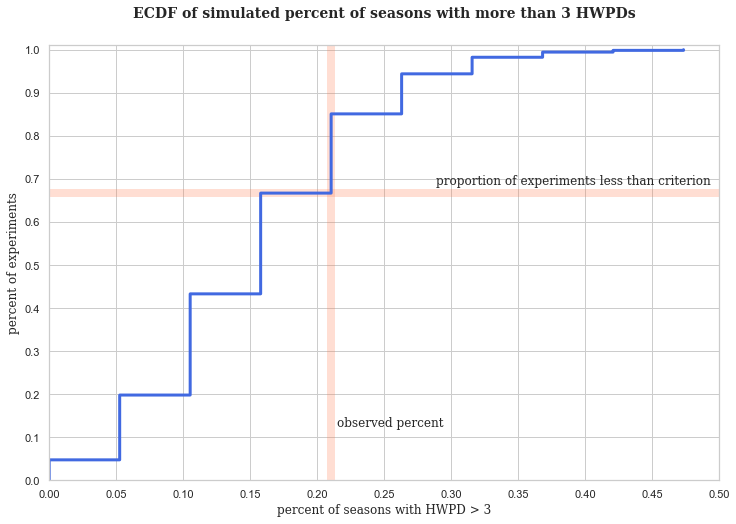

In [62]:
# draw ECDF
x_ecdf = np.sort(sim_gt_three)
y_ecdf = (np.arange(len(sim_gt_three)) + 1) / len(sim_gt_three)

plt.figure(figsize=(12,8))
plt.axvline(sum(dubuque_corn_prod.hwpd_gt_3) / len(dubuque_corn_prod),lw=8,color='coral',alpha=0.25)
plt.axhline(len(sim_gt_three[sim_gt_three < obs_prcnt]) / len(sim_gt_three),lw=8,color='coral',alpha=0.25)
plt.text(0.215,0.125,'observed percent',fontfamily='serif',fontsize=12)
plt.text(0.289,1 - modeled_prcnt + 0.02,'proportion of experiments less than criterion',fontfamily='serif',fontsize=12)
plt.step(x_ecdf,y_ecdf,where='post',color='royalblue',lw=3)
plt.title('ECDF of simulated percent of seasons with more than 3 HWPDs',y=1.05,
          fontsize=14,fontfamily='serif',fontweight='bold')
plt.xlabel('percent of seasons with HWPD > 3',fontfamily='serif')
plt.ylabel('percent of experiments',fontfamily='serif')
plt.yticks(np.linspace(0,1,11))
plt.xticks(np.linspace(0,0.5,11))
plt.xlim(0,0.5)
plt.ylim(0,1.01);

### What did we just do?

We constructed a statistic based on our model's output to evaluate a particular aspect that is important to us. We care about when the number of hot-wet planting days exceeds 3, because that significantly affects our cash flow. After we constructed the statistic, we conducted a series of experiments to assess how many times our modeled distribution produces a value of this statistic similar to the observed one. Because there was a significant divergence between the model and reality, we know our model is inadequate and needs to be updated.

This is one way we conduct **posterior predictive checking**.


# Posterior predictive checking

We want to kow if the data resembles the model close enough, and especially for things that are important to us. From Gelman's _Philosophy of Bayesian Statistics_

> The goal of model checking is not to demonstrate the foregone conclusion of falsity, but rather to learn how, in particular, this model fails (Gelman, 2003). When we find such particular failures, they tell us how the model must be improved; when severe tests cannot find them, the inferences we draw about those aspects of the real world from our fitted model become more credible. In designing a good test for model checking, we are interested in finding particular errors which, if present, would mess up particular inferences, and devise a test statistic which is sensitive to this sort of misspecification.

What Gelman is saying is if the model fits the data, then data simulated from the posterior predictive distribution should resemble the real data. What do we mean by "resemble"? What characteristics of the data should we test? That depends on the problem at hand. First, let's define more formally what we mean by the posterior predictive distribution.

From Gelman 2013 _Two simple examples for understanding posterior p-values_:
>In our work, all our models are false, and we know ahead of time that they could be clearly rejected given  sufficient data. We are working within a world in which the purpose of a diagnostic of fit is to reveal systematic differences between the model and some aspects of the data; if the model is false but its predictions fit the data, we do not want our test to reject. 

### What is the posterior predictive distribution?

The posterior predictive distribution is the distribution of data generated by a Bayesian model from the posterior distribution of parameters. 

### How do we construct the posterior predictive distribution?

Remember the Bayesian Two-Step for simulating data from the prior? Simulating from the posterior starts with drawing a value for each of your model's parameters from the posterior (rather than the prior), then generating a _dataset_. If you have 1,000 draws from your posterior after estimating a model in Stan, you can easily generate 1,000 _datasets_ from the posterior. 

We say _datasets_ because when sampling from the posterior predictive distribution you simulate a value for each observation in your dataset given a set of parameters. For example, if you have 100 data points, fit a two-parameter model using Stan, and return 1,000 draws from the posterior, you will generate 1,000 datasets each with 100 observations.

Notation for this:
* $y$ denotes the vector of observed data
* $\theta_{rep}$ represents a posterior draw of a model's parameters, $\theta_{rep} \, \sim \, P(\theta | y)$.
* $y_{rep}$ is a vector of observations produced from the model using $\theta_{rep}$.



## Setup

* Suppose we have a Bayesian model with parameter, $\theta$, and
* Continuous data $y$.
* We check the model with a _test statistic_ $T(y)$

We want to know whether our model can reliably replicate the test statistic, so we generate a series of datasets from our posterior, which we call $y_{rep}$. We compute the probability that $T(y_{rep})$ exceeds $T(y)$ as:

$P(T(y_{rep}) \, \geq \, T(y) | y) = \frac{1}{R} \sum_{r=1}^{R} 1(T(y_{r}) \, \geq \, T(y))$

When $\theta$ is known or estimated with a very high precision, the distribution of this p-value is uniform. In this scenario p-values less than 0.1 occur 10 percent of the time. More generally, we expect the distribution of the p-value is more likely to be near 0.5 than 0 or 1, ie the distribution of the p-value is stochastically less variable than uniform.

#### How do we read a p-value?
If a posterior p-vallue is 0.4, then we say that if we believe the model, then there is a 40 percent chance that tomorrow's value of $T(y_{rep})$ will exceed today's $T(y)$

## Back to our corn...

Let's return to the cornfields of Dubuque and see if we can improve our model. We will fit a zero-inflated Poisson model. This is an extension of the Poisson model for situations in which we have lots of zeros. Let's see how this improves our fit.

A zero-inflated Poisson model mixes binomial and Poisson distributions to account for a large number of zeros. $\theta$ represents the probability of seeing a zero.

If the count is zero, then the likelihood is:

$\theta + (1 - \theta) * \mathrm{Poisson}(0 | \lambda)$

If the count is greater than zero, then the likelihood is:

$(1 - \theta) * \mathrm{Poisson}(y_i | \lambda)$


In [63]:
# a stan model to fit a poisson distribution
f = open('../stan/iowa_hwpd_zero_inflated.stan', 'r')
file_contents = f.read()
print (file_contents)
f.close()

// fit a zero-inflated poisson model to the number of HWPDs in Dubuqe
data {
  int<lower=1> N; // number of datapoints
  int hwpd[N];    // random variable
}
parameters {
  real<lower=0> lambda;         // rate of events
  real<lower=0, upper=1> theta; // probability of a zero
}
model {
  // priors
  lambda ~ normal(0,5);
  theta ~ beta(1,1);

  // likelihood
  // Observational model that mixes a Poisson with excess zeros
  for (n in 1:N) {
    real lpdf = poisson_lpmf(hwpd[n] | lambda);
    if (hwpd[n] == 0)
      target += log_mix(theta, 0, lpdf);
    else
      target += log(1 - theta) + lpdf;
  }

}
generated quantities {
    // Simulate data from posterior
    int hwpd_sim[N] = rep_array(0, N);
    for (n in 1:N)
      if (!bernoulli_rng(theta))
        hwpd_sim[n] = poisson_rng(lambda);
  }
}



In [67]:
zim = pystan.StanModel(file='../stan/iowa_hwpd_zero_inflated.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_83cfae8057c1265c6638976fc0fe41fc NOW.


In [68]:
# feed stan some data
hwpd_dict = {'N':len(dubuque_corn_prod.hot_wet_planting),'hwpd':dubuque_corn_prod.hot_wet_planting}

In [69]:
# conduct MCMC using Stan
zim_draws = zim.sampling(data=hwpd_dict, iter=1000, chains=4)

In [70]:
# give us a dictionary containing posterior draws for each parameter in the model
zim_pstr = zim_draws.extract(permuted=True)

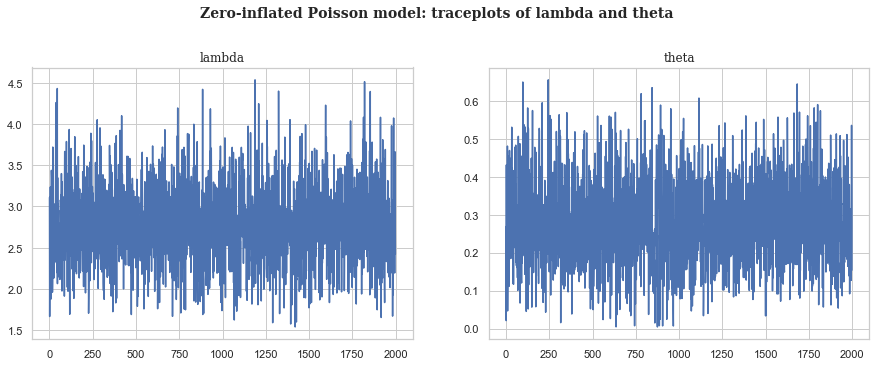

In [80]:
# Initialise the figure and a subplot axes.
num_rows = 1
num_cols = 2
fig, ax = plt.subplots(num_rows, num_cols, figsize=(15, 5),sharex=False,sharey=False)

# overall title
fig.suptitle('Zero-inflated Poisson model: traceplots of lambda and theta',
             y=1.05,fontsize=14,fontfamily='serif',fontweight='bold')
    
ax[0].plot(zim_pstr['lambda'])
ax[1].plot(zim_pstr['theta'])
ax[0].set_title('lambda',fontsize=12,fontfamily='serif')
ax[1].set_title('theta',fontsize=12,fontfamily='serif');

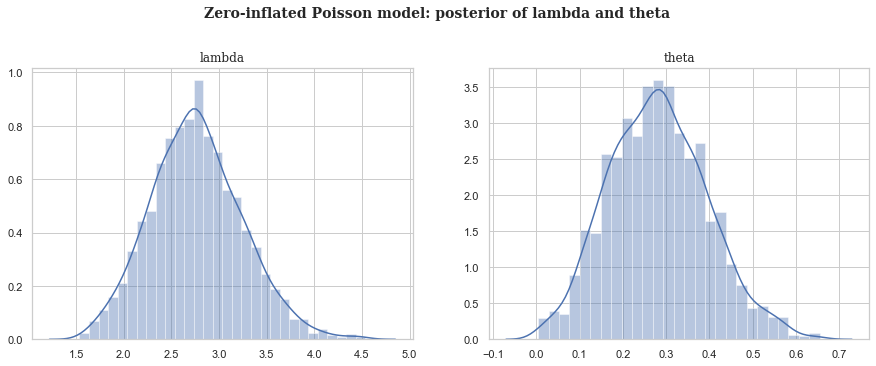

In [81]:
# Initialise the figure and a subplot axes.
num_rows = 1
num_cols = 2
fig, ax = plt.subplots(num_rows, num_cols, figsize=(15, 5),sharex=False,sharey=False)

# overall title
fig.suptitle('Zero-inflated Poisson model: posterior of lambda and theta',
             y=1.05,fontsize=14,fontfamily='serif',fontweight='bold')
    
sns.distplot(zim_pstr['lambda'],ax=ax[0])
sns.distplot(zim_pstr['theta'],ax=ax[1])
ax[0].set_title('lambda',fontsize=12,fontfamily='serif')
ax[1].set_title('theta',fontsize=12,fontfamily='serif');

Freeing the Poisson distribution from having to generate a large number of zeros, allowed the mean number of events to shift higher and better model the distribution.

In [110]:
np.mean(zim_pstr['lambda'])

2.7661264513801425

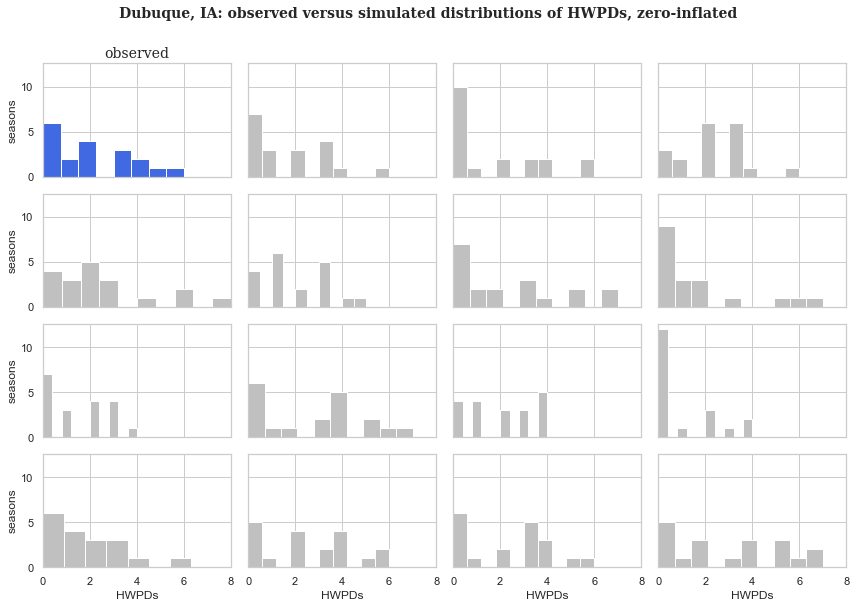

In [120]:
# Initialise the figure and a subplot axes.
num_rows = 4
num_cols = 4
fig, ax = plt.subplots(num_rows, num_cols, figsize=(12, 8),sharex=True,sharey=True)

# let's pick 8 random posterior samples
idx = np.random.choice(np.arange(zim_pstr['hwpd_sim'].shape[0]),size=16,replace=False)

# overall title
fig.suptitle('Dubuque, IA: observed versus simulated distributions of HWPDs, zero-inflated',
             y=1.05,fontsize=14,fontfamily='serif',fontweight='bold')

# plots of poissons
c = 0
for i in range(num_rows):
    for j in range(num_cols):
        if i == 0 and j == 0:
            # observed data
            ax[0,0].hist(dubuque_corn_prod.hot_wet_planting,bins=8,density=False,color='royalblue')
            ax[0,0].set_xlim(0,8)
            ax[0,0].set_title('observed',fontsize=14,fontfamily='serif')
        else:
            # simulated data plots
            ax[i,j].hist(zim_pstr['hwpd_sim'][idx[c],:],density=False,color='silver')
            c += 1
            
        # label
        if j == 0:
            ax[i,j].set_ylabel('seasons')
        if i == num_rows - 1:
            ax[i,j].set_xlabel('HWPDs')

# make the plot prettier
plt.tight_layout()
plt.show();

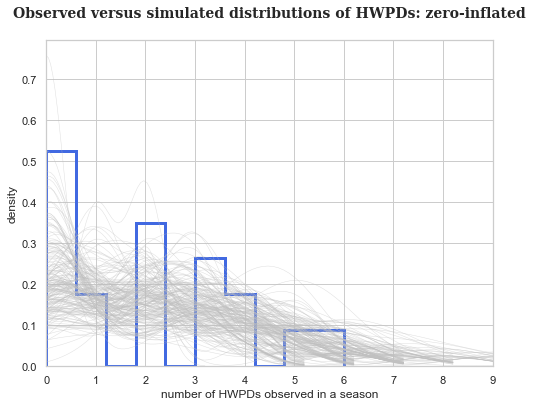

In [97]:
# let's pick 8 random posterior samples
num_samp = 200
idx = np.random.choice(np.arange(zim_pstr['hwpd_sim'].shape[0]),size=num_samp,replace=False)

plt.figure(figsize=(8,6))

# plot samples from posterior
for i in range(num_samp):
    sns.kdeplot(zim_pstr['hwpd_sim'][idx[i],:],lw=0.5,bw=0.4,alpha=0.5,color='silver')

# plot data
plt.hist(dubuque_corn_prod.hot_wet_planting,histtype='step',density=True,lw=3,color='royalblue',label='observed')

# label
plt.title('Observed versus simulated distributions of HWPDs: zero-inflated',
             y=1.05,fontsize=14,fontfamily='serif',fontweight='bold')
plt.xlabel('number of HWPDs observed in a season')
plt.ylabel('density')
plt.xlim(0,9);

### Let's run through our previous test statistic and see if we improved the fits

In [98]:
# get number of experiments from previously estimated Stan model
num_expr = zim_pstr['hwpd_sim'].shape[0]

# sample from a poisson distribution with mean 2
poisson_expr = np.array(zim_pstr['hwpd_sim'].reshape(num_expr*len(dubuque_corn_prod)),dtype=int)
expr_idx = np.mod(np.arange(num_expr*len(dubuque_corn_prod)),num_expr)+1

# put it in a dataframe
expr_df = pd.DataFrame(np.vstack([expr_idx,poisson_expr]).T,columns=['experiment','num_hwpd'])

# create an indicator variable to count number of HWPD
expr_df['gt_three'] = [1 if x > 3 else 0 for x in expr_df.num_hwpd]
expr_df.head(10)

,experiment,num_hwpd,gt_three
0,1,4,1
1,2,1,0
2,3,4,1
3,4,2,0
4,5,0,0
5,6,2,0
6,7,5,1
7,8,2,0
8,9,4,1
9,10,3,0


In [99]:
# we use pandas groupby to compute the percent of HWPD > 3 for each experiment
sim_gt_three = expr_df.groupby(['experiment']).sum()['gt_three'] / len(dubuque_corn_prod)

In [100]:
# how many years with HWPD > 3 in each experiment?
expr_df.groupby(['experiment']).sum()[['gt_three']].head()

,gt_three
experiment,
1,5
2,5
3,5
4,3
5,4


#### What do some of these experiments looks like?

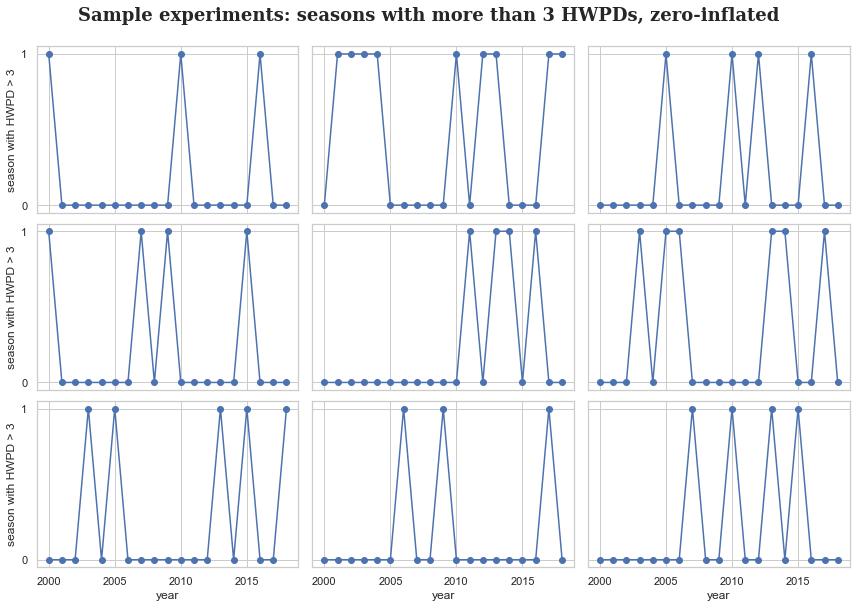

In [111]:
# Initialise the figure and a subplot axes.
num_rows = 3
num_cols = 3
fig, ax = plt.subplots(num_rows, num_cols, figsize=(12, 8),sharex=True,sharey=True)

# pick num_rows * num_cols
idx = np.random.choice(np.arange(num_expr),num_rows*num_cols,replace=False)

# x labels
xlabels = 2000 + np.arange(len(dubuque_corn_prod))

# overall title
fig.suptitle('Sample experiments: seasons with more than 3 HWPDs, zero-inflated',
             y=1.05,fontsize=18,fontfamily='serif',fontweight='bold')

c = 0

for i in range(num_rows):
    for j in range(num_cols):
        ax[i,j].plot(xlabels,expr_df[expr_df.experiment == idx[c]].gt_three,'o-')
        ax[i,j].set_yticks([0,1])
        if i == (num_rows - 1):
            ax[i,j].set_xlabel('year')
            
        if j == 0:
            ax[i,j].set_ylabel('season with HWPD > 3')
        c += 1
                             
# make the plot prettier
plt.tight_layout()
plt.show();

#### What does the distribution of the number of seasons with HWPD > 3 look like?

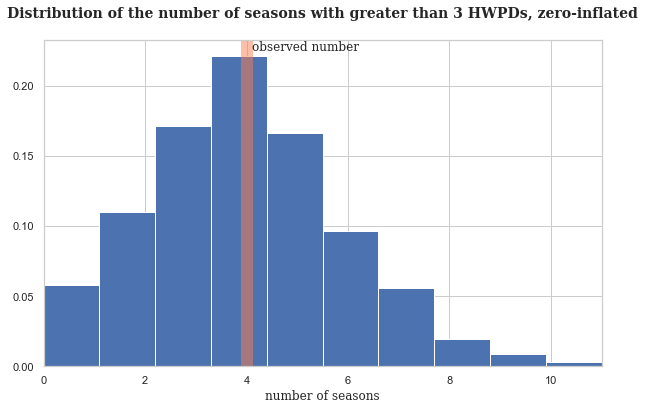

In [114]:
plt.figure(figsize=(10,6))
plt.hist(expr_df.groupby(['experiment']).sum()['gt_three'],density=True,bins=10,label='')
plt.axvline(sum(dubuque_corn_prod.hwpd_gt_3),lw=12,alpha=0.5,color='coral')
plt.text(4.1,0.225,'observed number',fontfamily='serif',fontsize=12)
plt.title('Distribution of the number of seasons with greater than 3 HWPDs, zero-inflated',y=1.05,
          fontsize=14,fontfamily='serif',fontweight='bold')
plt.xlabel('number of seasons',fontfamily='serif')
plt.xlim(0,11);

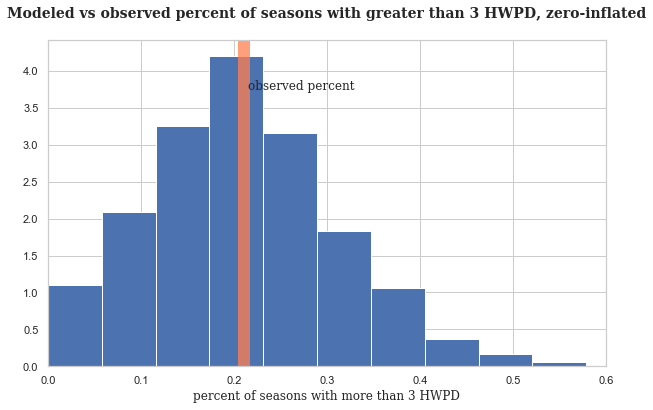

In [116]:
plt.figure(figsize=(10,6))
plt.hist(sim_gt_three,density=True,bins=10,label='')
plt.axvline(sum(dubuque_corn_prod.hwpd_gt_3) / len(dubuque_corn_prod),lw=12,alpha=0.75,color='coral')
plt.text(0.215,3.75,'observed percent',fontfamily='serif',fontsize=12)
plt.title('Modeled vs observed percent of seasons with greater than 3 HWPD, zero-inflated',y=1.05,
          fontsize=14,fontfamily='serif',fontweight='bold')
plt.xlabel('percent of seasons with more than 3 HWPD',fontfamily='serif')
plt.xlim(0,0.6);

### Do we have a good model?

If our model is correct, we would expect to observe an average of 4 growing seasons with more than 3 HWPDs in a 19 year period. Instead we expect 2.76 seasons with more than 3 HWPDs:

In [104]:
np.mean(expr_df.groupby(['experiment']).sum()['gt_three'])

4.101

How often does our model produce 4 or more years that meet our criterion?

In [105]:
# observed percentage of years in a 19 year period with more than 3 HWPD
obs_prcnt = sum(dubuque_corn_prod.hwpd_gt_3) / len(dubuque_corn_prod)

# how many times do we observe that or more in the model?
modeled_prcnt = len(sim_gt_three[sim_gt_three >= obs_prcnt]) / len(sim_gt_three)
print(modeled_prcnt)

0.627


This means that we observe less than 4 about 63 percent of the time and more than or equal to 4 about 37 percent of the time. So our model does a much better job of predicting our statistic of interest.

Again plotting the empirical CDF of the percent of seasons meeting our criterion over all experiments.

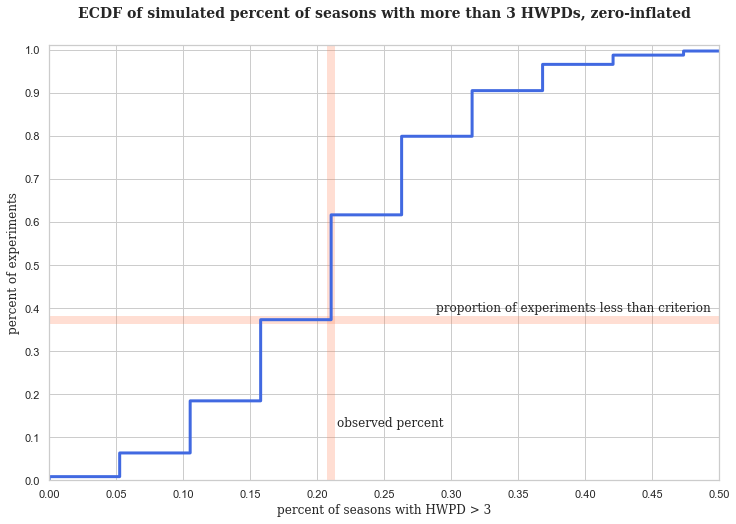

In [107]:
# draw ECDF
x_ecdf = np.sort(sim_gt_three)
y_ecdf = (np.arange(len(sim_gt_three)) + 1) / len(sim_gt_three)

plt.figure(figsize=(12,8))
plt.axvline(sum(dubuque_corn_prod.hwpd_gt_3) / len(dubuque_corn_prod),lw=8,color='coral',alpha=0.25)
plt.axhline(len(sim_gt_three[sim_gt_three < obs_prcnt]) / len(sim_gt_three),lw=8,color='coral',alpha=0.25)
plt.text(0.215,0.125,'observed percent',fontfamily='serif',fontsize=12)
plt.text(0.289,1 - modeled_prcnt + 0.02,'proportion of experiments less than criterion',fontfamily='serif',fontsize=12)
plt.step(x_ecdf,y_ecdf,where='post',color='royalblue',lw=3)
plt.title('ECDF of simulated percent of seasons with more than 3 HWPDs, zero-inflated',y=1.05,
          fontsize=14,fontfamily='serif',fontweight='bold')
plt.xlabel('percent of seasons with HWPD > 3',fontfamily='serif')
plt.ylabel('percent of experiments',fontfamily='serif')
plt.yticks(np.linspace(0,1,11))
plt.xticks(np.linspace(0,0.5,11))
plt.xlim(0,0.5)
plt.ylim(0,1.01);